### Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients. The ridge coefficients minimize a penalized residual sum of squares

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('../common')

from print_more_stuff import print_more_stuff
from preprocessing import mean_and_std
from regression_models import dosomething

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
outliers_df = pd.read_csv('geocoded.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12242 entries, 0 to 12241
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    12242 non-null  int64  
 1   bed             12242 non-null  float64
 2   bath            12242 non-null  float64
 3   acre_lot        12242 non-null  float64
 4   zip_code        12242 non-null  float64
 5   house_size      12242 non-null  float64
 6   prev_sold_date  12242 non-null  object 
 7   price           12242 non-null  float64
 8   prev_sold_year  12242 non-null  int64  
 9   zip_code_str    12242 non-null  int64  
 10  latitude        12242 non-null  float64
 11  longitude       12242 non-null  float64
 12  county          12242 non-null  int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 1.2+ MB


#### Find the zip code of that has the most houses.

In [4]:
groupby_zipcode = outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)
groupby_zipcode_df = pd.DataFrame(groupby_zipcode).rename(columns={"zip_code":"count"}).reset_index()
first_zipcode = groupby_zipcode_df.iloc[0]["zip_code"]
first_zipcode

10023.0

In [5]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([first_zipcode])]

In [6]:
one_zipcode_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 3689 to 3838
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    150 non-null    int64  
 1   bed             150 non-null    float64
 2   bath            150 non-null    float64
 3   acre_lot        150 non-null    float64
 4   zip_code        150 non-null    float64
 5   house_size      150 non-null    float64
 6   prev_sold_date  150 non-null    object 
 7   price           150 non-null    float64
 8   prev_sold_year  150 non-null    int64  
 9   zip_code_str    150 non-null    int64  
 10  latitude        150 non-null    float64
 11  longitude       150 non-null    float64
 12  county          150 non-null    int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 16.4+ KB


#### Create an object to pass to the function that will normalize the data

In [7]:
params = {
    "data":one_zipcode_df,
    "features_a":["prev_sold_year","zip_code","latitude","longitude"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
}
normalize_df = mean_and_std(params)
#normalize_df = outliers_df
normalize_df.tail()

,bed,bath,acre_lot,house_size,price,prev_sold_year,zip_code,latitude,longitude
3834,0.158628,0.278238,-0.197783,-0.097337,0.013886,2017,10023.0,40.775921,-73.982607
3835,-0.974429,-0.739706,-0.197783,-0.097337,-0.230905,2017,10023.0,40.775921,-73.982607
3836,0.158628,0.278238,-0.197783,-0.097337,-0.106920,2019,10023.0,40.775921,-73.982607
3837,0.158628,0.278238,-0.197783,-0.097337,-0.361248,2019,10023.0,40.775921,-73.982607
3838,1.291685,-0.739706,-0.197783,-0.097337,-0.908053,2017,10023.0,40.775921,-73.982607


#### Create a variable for the correlation of the normalized data

In [8]:
correlation = normalize_df[["acre_lot","bed","bath","house_size","prev_sold_year","price"]].corr()
correlation["price"]

acre_lot          0.170108
bed               0.626874
bath              0.909782
house_size        0.798127
prev_sold_year   -0.017182
price             1.000000
Name: price, dtype: float64

#### Display a Heatmap with the correlated data

Text(0.5, 1.0, 'Correlation Between Variables')

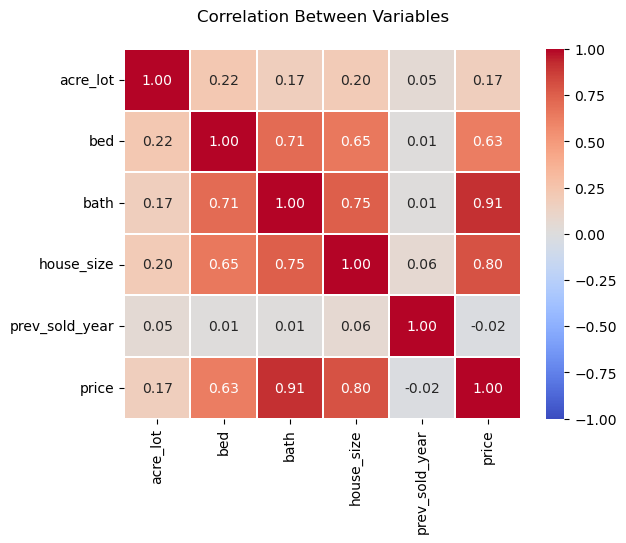

In [9]:
sns.heatmap(correlation, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

#### Create a variable to hold the features that correlate with the price feature between 0.20 and 0.80

In [10]:
'''
'''
savefeatures = ["latitude","longitude"]
for feature, value in correlation["price"].items():
    if abs(value) < 0.81 and abs(value) >= 0.20:
        savefeatures.append(feature)

print(savefeatures)

['latitude', 'longitude', 'bed', 'house_size']


#### Create common variables to store frequently used values.

In [11]:
features = savefeatures
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [12]:
X = normalize_df[features]
y = normalize_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [13]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [14]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

#### Use Grid Search CV to find the best Hyperparameters for Ridge Regression

In [15]:
ridge_gscv = GridSearchCV(Ridge(random_state=42), {'alpha': [1e-11, 1e-10, 1e-9]}, scoring='neg_mean_squared_error')
ridge_gscv_model = ridge_gscv.fit(X, y)
print(f"Best parameters found: {ridge_gscv.best_params_}")

Best parameters found: {'alpha': 1e-11}


#### The best params attribute will be used to fit  model with the training data and make a prediction with the test data.

In [16]:
ridge_bp = dosomething("Ridge","Best Params", normalize_df, features, "price", ridge_gscv.best_params_)
results_dict_append(ridge_bp["results"])
ridge_bp_predict = ridge_bp["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'house_size']
Best Params EVS = 0.681201943
Best Params MSE = 0.283510
Best Params MAE = 0.458867
Best Params R2 = 0.667712
Best Params Fit Time = 0.0


### SelectFromModel is a meta-transformer that can be used alongside any estimator that assigns importance to each feature through a specific attribute or via an importance_getter callable after fitting. The features are considered unimportant and removed if the corresponding importance of the feature values are below the provided threshold parameter.

In [17]:
ridge_sfm = dosomething("Ridge","Select From Model", normalize_df, features, "price")
results_dict_append(ridge_sfm["results"])
ridge_sfm_predict = ridge_sfm["predictions"]

The selected features are: ['house_size']
Select From Model EVS = 0.650200104
Select From Model MSE = 0.313843
Select From Model MAE = 0.490030
Select From Model R2 = 0.632160
Select From Model Fit Time = 0.0


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [18]:
ridge_sfs = dosomething("Ridge","Sequential Feature Selector", normalize_df, features, "price")
results_dict_append(ridge_sfs["results"])
ridge_sfs_predict = ridge_sfs["predictions"]

The selected features are: ['latitude', 'bed', 'house_size']
Sequential Feature Selector EVS = 0.681264616
Sequential Feature Selector MSE = 0.283273
Sequential Feature Selector MAE = 0.457678
Sequential Feature Selector R2 = 0.667990
Sequential Feature Selector Fit Time = 0.0


### Recursive feature elimination uses an external estimator that assigns weights to features with the goal of selecting features by recursively considering smaller and smaller sets of features.

In [19]:
ridge_rfe = dosomething("Ridge","Recursive Feature Elimination", normalize_df, features, "price")
results_dict_append(ridge_rfe["results"])
ridge_rfe_predict = ridge_rfe["predictions"]

The selected features are: ['longitude', 'bed', 'house_size']
Recursive Feature Elimination EVS = 0.681264616
Recursive Feature Elimination MSE = 0.283273
Recursive Feature Elimination MAE = 0.457678
Recursive Feature Elimination R2 = 0.667990
Recursive Feature Elimination Fit Time = 0.0


#### Graphing the results works best when the data is provided in a DataFrame.

In [20]:
ridge_bp_predict_df = pd.DataFrame(ridge_bp_predict).reset_index()
ridge_bp_predict_df.rename(columns={0: "prediction"},inplace=True)

ridge_sfm_predict_df = pd.DataFrame(ridge_sfm_predict).reset_index()
ridge_sfm_predict_df.rename(columns={0: "prediction"},inplace=True)

ridge_sfs_predict_df = pd.DataFrame(ridge_sfs_predict).reset_index()
ridge_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

ridge_rfe_predict_df = pd.DataFrame(ridge_rfe_predict).reset_index()
ridge_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

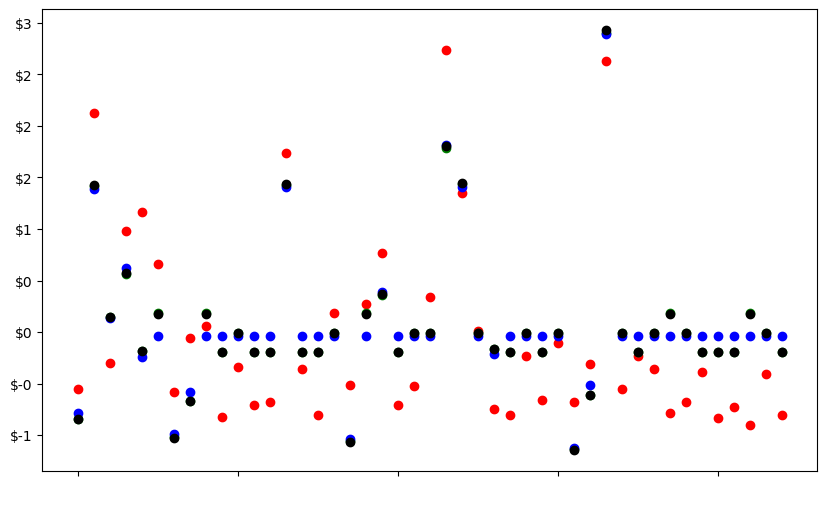

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(ridge_sfs_predict_df.index,ridge_sfs_predict_df["prediction"], color="green")
plt.scatter(ridge_sfm_predict_df.index,ridge_sfm_predict_df["prediction"], color="blue")
plt.scatter(ridge_bp_predict_df.index,ridge_bp_predict_df["prediction"], color="black")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [22]:
results_dict

{'model': ['Best Params',
  'Select From Model',
  'Sequential Feature Selector',
  'Recursive Feature Elimination'],
 'explained variance score': ['0.681201943',
  '0.650200104',
  '0.681264616',
  '0.681264616'],
 'mae score': ['0.458867', '0.490030', '0.457678', '0.457678'],
 'mse score': ['0.283510', '0.313843', '0.283273', '0.283273'],
 'r2 score': ['0.667712', '0.632160', '0.667990', '0.667990'],
 'mean fit time': [0.0, 0.0, 0.0, 0.0]}

In [23]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Best Params,0.681201943,0.458867,0.283510,0.667712,0.0
Select From Model,0.650200104,0.490030,0.313843,0.632160,0.0
Sequential Feature Selector,0.681264616,0.457678,0.283273,0.667990,0.0
Recursive Feature Elimination,0.681264616,0.457678,0.283273,0.667990,0.0
